In [19]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from algbench import read_as_pandas, Benchmark
import re
from collections import defaultdict
import matplotlib.ticker as mtick

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [4.5, 3.5]

sns.set_theme()

result_paths = ['results/classical_benchmark/qtg/hard'] #'results/classical_benchmark/qtg/hard']

In [20]:
def _row_correction(row):
    # this function makes sure that the values in the results are uniform even though they are not
    # produced by the same solver
    
    def set_infeasible():
        row['result']['objective_value'] = np.inf
        row['result']['item_assignments'] = None
        row['result']['feasible'] = False
        row['result']['optimal'] = False
    
    row['result']['feasible'] = True
    row['result']['objective_value'] = round(row['result']['objective_value'])
    if row['result']['objective_value'] < 0:
        set_infeasible()
    
    if row['result']['item_assignments']:
        items = row['parameters']['args']['instance']['items']
        obj_val = sum(items[i]["profit"] for i, x in enumerate(row['result']['item_assignments']) if x == True)
        
        if round(row['result']['objective_value']) != obj_val:
            # There was an numerical error during the computation.
            set_infeasible()
    else:
        set_infeasible()
            
    if "best_bound" in row["result"] and row["result"]["feasible"]:
        row["result"]["best_bound"] = round(row["result"]["best_bound"])
        
        if row["result"]["best_bound"] < row['result']['objective_value']:
            row["result"]["best_bound"] = np.inf
    else: 
        row["result"]["best_bound"] = np.inf
    
    return row

In [21]:
max_instance_size = 3000
best_bounds = defaultdict(lambda: np.inf)
best_solution = defaultdict(int)
instance_solved = defaultdict(int)
total_instances = 0

for path in result_paths:
    solutions = [_row_correction(row) for row in Benchmark(path) 
        if row['parameters']['args']['instance']['size'] <= max_instance_size]
        
    for row in solutions:
        instance_name = row['parameters']['args']['instance']['name']        
        instance_solved[instance_name] += 1
        
        if row['result']['feasible']:
            best_solution[instance_name] = max(row['result']['objective_value'], best_solution[instance_name])
            best_bounds[instance_name] = min(row['result']['best_bound'], best_bounds[instance_name])

        assert row['parameters']['args']['solver'] != "combo" or row['result']['best_bound'] == row['result'][
                'objective_value'], f"{row['result']['best_bound']} != {row['result']['objective_value']}"

    total_instances += len(Benchmark(path))
    
    for row in solutions:
        instance_name = row['parameters']['args']['instance']['name']  
        if row['result']['feasible'] and row['result']['objective_value'] > best_bounds[instance_name]:
            print(f"{row['result']['objective_value']} > {best_bounds[instance_name]} {row['parameters']['args']['solver']} {instance_name}")

removed_instances = [instance for instance, count in instance_solved.items() if count != 5]

for instance in removed_instances:
    if instance in best_bounds: del best_bounds[instance]
    del best_solution[instance]
    del instance_solved[instance]

print(f"Instances not solved 4 times", [(instance, count) for instance, count in instance_solved.items() if count != 5])
print(f"Total instances: {total_instances}")
print(f"Instances solved by all algorithms: {len(best_bounds)}")

assert all([best_solution[instance] == best_bounds[instance] for instance in
            best_bounds]), f"Best solution is not equal to best bound for some instances {[(instance, best_solution[instance], best_bounds[instance]) for instance in best_bounds if best_solution[instance] != best_bounds[instance]]}"

assert len(
    best_bounds) == total_instances / 5, f"Not all instances were solved by all algorithms or some instances were solved multiple times {len(best_bounds)} != {total_instances / 5}"


Instances not solved 4 times []
Total instances: 1680
Instances solved by all algorithms: 336


In [22]:
def parse_row(row):
    row = _row_correction(row)
    is_feasible = row['result']['feasible']
    instance_name = row['parameters']['args']['instance']['name']
    
    if instance_name not in instance_solved:
        return None
    
    if is_feasible:
        gap = np.abs(best_bounds[instance_name] -
                      row['result']['objective_value']) / np.abs(row['result']['objective_value'])
    else:
        gap = np.inf
    
    local_gap = np.inf
    
    if "best_bound" in row["result"]:
        local_gap = np.abs(row['result']['best_bound']-row['result']['objective_value']) / np.abs(row['result']['objective_value'])
    
    # parse g from instance name. it is of form *g_x_*
    g = int(re.match(r'.+\_g\_([0-9]+)\_.+', instance_name).group(1)) if re.match(r'.+\_g\_([0-9]+)\_.+', instance_name) else 0
    
    #instance_type = re.match(r'(.+)_.+_.+', instance_name).group(1)
    instance_type = re.match(r'(.+)...\.knap', instance_name).group(1)
    
    return {
        'algorithm': row['parameters']['args']['solver'],
        'size': row['parameters']['args']['instance']['size'],
        'elapsed_real_time': (row['result']['elapsed_real_time']),
        'instance': instance_name,
        'instance_type': instance_type,
        'feasible': is_feasible,
        'g': g,
        'infeasible':not is_feasible,
        'gap': gap,
        'local_gap': local_gap,
        'objective_value': row['result']['objective_value'],
        'optimal': gap <= 1e-4 # MIP gap of Gurobi
    }


results = pd.concat([read_as_pandas(path, parse_row) for path in result_paths])
results.sort_values(by=['algorithm', 'size'], inplace=True)

evaluation_bins = list(range(50,max_instance_size+150,150))
group_names = [f"{evaluation_bins[i]}-{evaluation_bins[i+1]}" for i in range(len(evaluation_bins)-1)] 

results['size_bins'] = pd.cut(results['size'], bins=evaluation_bins, 
                                labels=group_names, include_lowest=True, right=False)
print("Loaded results", len(results))

Loaded results 1680


In [23]:
print(results["instance_type"].unique())

['n_200_c_100000_g_3_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_9_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_4_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_7_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_6_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_5_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_2_f_0.3_eps_1e-05_s_'
 'n_200_c_100000_g_8_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_8_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_6_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_2_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_7_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_9_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_3_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_4_f_0.3_eps_1e-05_s_'
 'n_400_c_100000_g_5_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_6_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_2_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_4_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_9_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_8_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_3_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_7_f_0.3_eps_1e-05_s_'
 'n_600_c_100000_g_5_f_0.3_eps_1e-05_s_'
 'n_800_c_100000

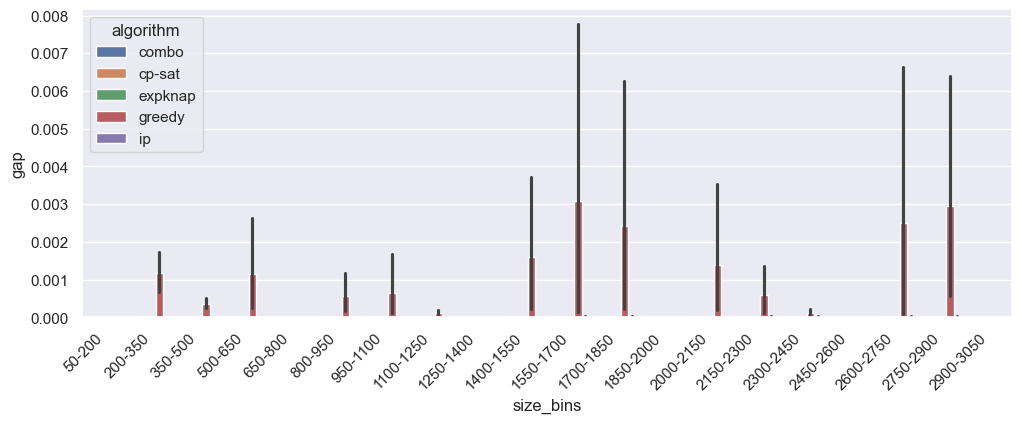

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=results[(results["feasible"] ==True)], x='size_bins', y='gap', hue='algorithm', dodge=True, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

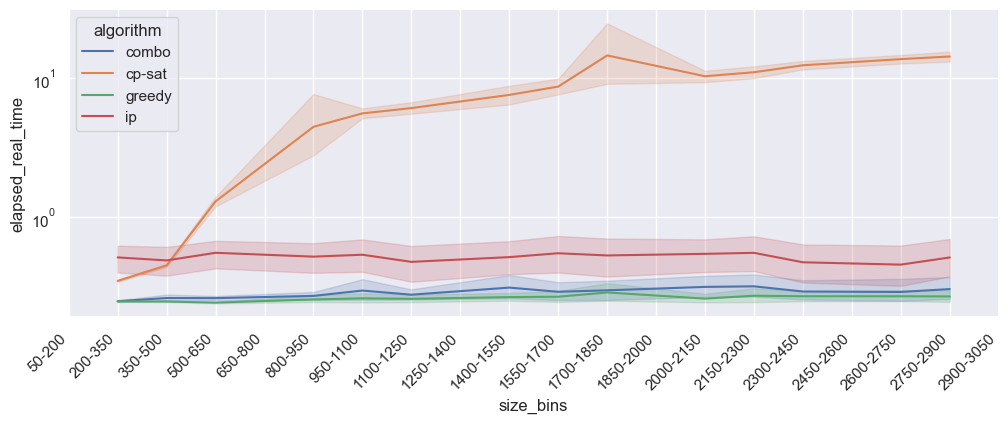

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=results[(results["algorithm"] != "expknap")], x='size_bins', y='elapsed_real_time', hue='algorithm', ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yscale("log")
plt.show()

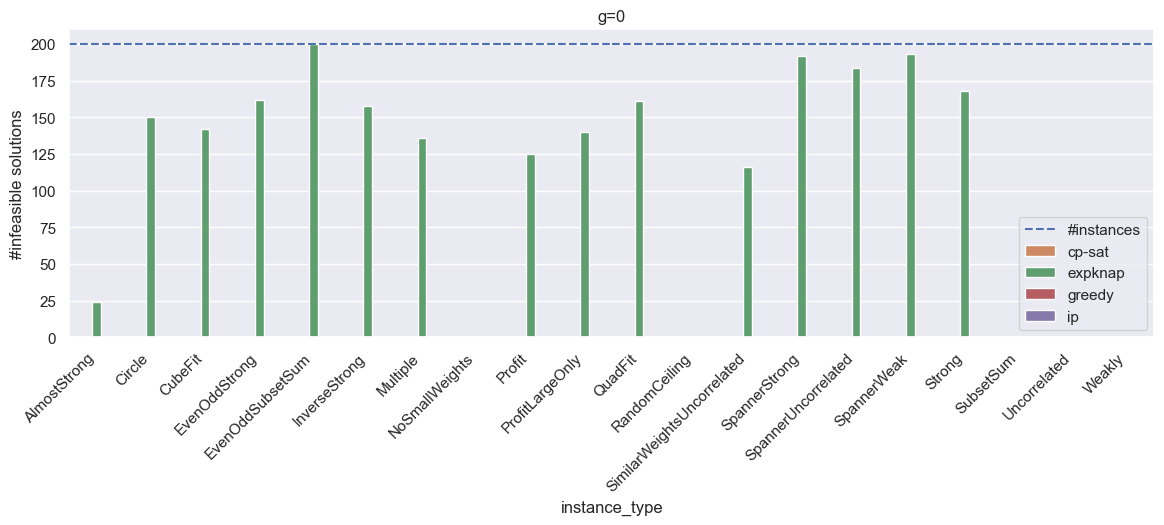

In [37]:
for g in sorted(results['g'].unique()):
    current_results = results[results['g'] == g]
    
    how_many_infeasible = current_results.groupby(['algorithm', 'instance_type'], observed=True)['infeasible'].sum().reset_index()
    how_many_feasible = current_results.groupby(['algorithm', 'instance_type'], observed=True)['feasible'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    for i, row in how_many_feasible.iterrows():
        if row['algorithm'] != "combo":
            continue
        ax.plot([i-0.5, i+0.5], [row['feasible'], row['feasible']], color='C0', linestyle='--', label="#instances" if i == 0 else None)
    
    sns.barplot(data=how_many_infeasible[how_many_infeasible["algorithm"] != "combo"], x='instance_type', y='infeasible', hue='algorithm', hue_order=["combo", "cp-sat", "expknap", "greedy", "ip"], ax=ax)
    
    #ax.set_ylim(0, 19)
    #ax.set_yticks(list(range(0, 20, 2)))
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("#infeasible solutions")
    legend = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    
    
    ax.legend(handles=handles[:1]+handles[2:], labels=labels[:1]+labels[2:])
    ax.set_title(f"g={g}")
    
    fig.savefig(f"infeasible_{g}.pdf", bbox_inches='tight')
    
    plt.show()

Index(['algorithm', 'instance_type', 'optimal'], dtype='object')


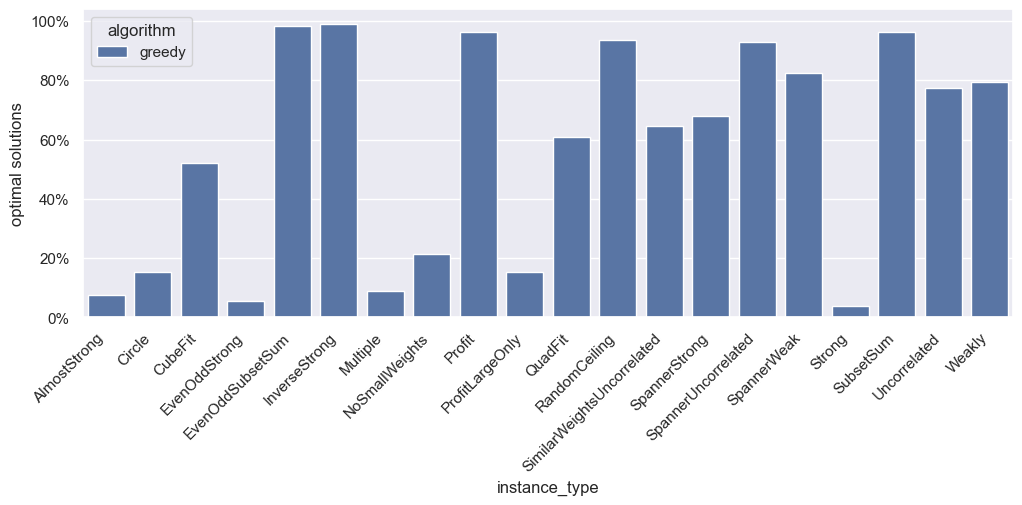

In [62]:
size_measure = "instance_type"
how_many_optimal = results.groupby(['algorithm', size_measure], observed=True)['optimal'].sum().reset_index()

print(how_many_optimal.columns)
how_many_optimal['optimal'] = how_many_optimal.apply(lambda row: row["optimal"] / len(results[(results['algorithm'] == "combo") & (results[size_measure] == row[size_measure])]), axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=how_many_optimal[(how_many_optimal["algorithm"] != "expknap") & (how_many_optimal["algorithm"] != "combo") & (how_many_optimal["optimal"] < 1)], x=size_measure, y='optimal', hue='algorithm', ax=ax)

# format y axis in percent
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("optimal solutions")
plt.show()

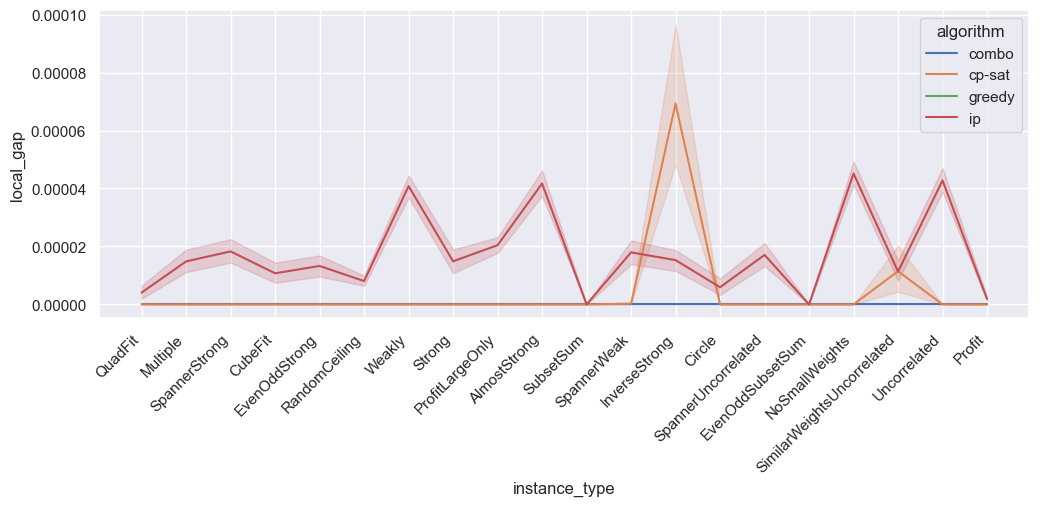

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=results[(results["algorithm"] != "expknap")], x='instance_type', y='local_gap', hue='algorithm', ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

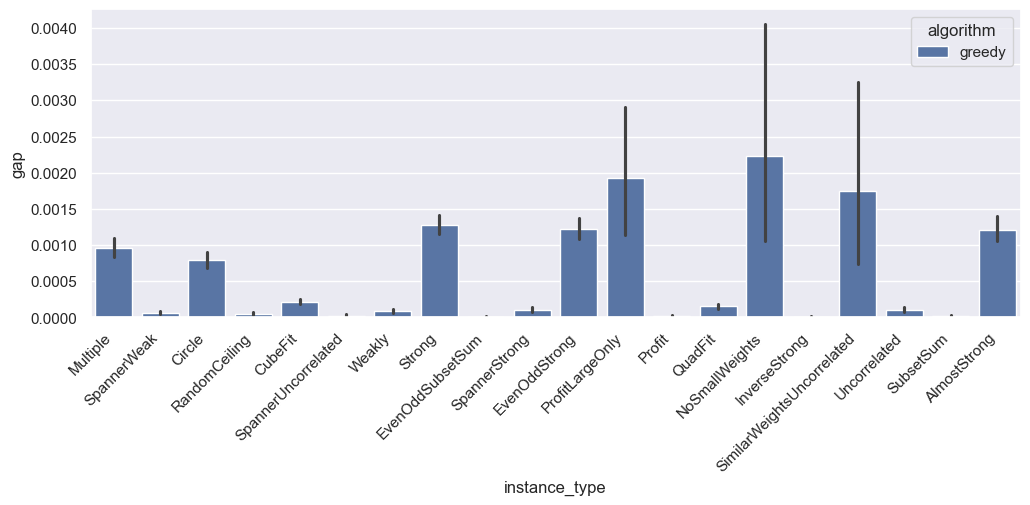

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=results[(results["algorithm"] == "greedy")], x='instance_type', y='gap', hue='algorithm', dodge=True, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()